In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
#load in all the data sets

# kaggle_train = pd.read_csv('datasets/kaggle-data/train_essays.csv') 
# kaggle_prompts = pd.read_csv('datasets/kaggle-data/train_prompts.csv')

#The DAIGT_concatenated dataset can be downloaded from: https://www.kaggle.com/datasets/dsluciano/daigt-one-place-all-data?select=concatenated.csv
daigt_external_data = pd.read_csv('DAIGT_concatenated.csv')

# test_data_fixed = pd.read_csv('datasets/external-data/test_preprocessed_fixed.csv')
# # train_essays_v1 = pd.read_csv('datasets/external-data/train_essays_RDizzl3_seven_v1.csv')
# # train_data_fixed = pd.read_csv('datasets/external-data/train_preprocessed_fixed.csv')
# # train_v2_raw = pd.read_csv('datasets/external-data/train_v2_drcat_02_raw.csv')


In [4]:
# Count 1s and 0s in 'generated' column for daigt_external_data
daigt_external_counts = daigt_external_data['generated'].value_counts()

print("\nDAIGT External Data - 'generated' column counts:")
print(daigt_external_counts)


DAIGT External Data - 'generated' column counts:
generated
0    29907
1    24784
Name: count, dtype: int64


Based on the above output (Kaggle Train - 'generated' column counts:
0    1375
1       3
DAIGT External Data - 'generated' column counts:
0    29907
1    24784), 
we disregard the Kaggle training set and work with the compiled externel DAIGT data set instead.

In [5]:
daigt_external_data.head()

,id,prompt_id,text,generated,model,kaggle_repo
0,d429f032,0,Advantages of Limiting Car Usage \n\nLimiting ...,1,gpt-3.5-turbo,1
1,1ce279be,0,Advantages of Limiting Car Usage\n\nLimiting c...,1,gpt-3.5-turbo,1
2,c9595213,0,Limiting car usage has numerous advantages tha...,1,gpt-3.5-turbo,1
3,f2266d87,0,The passages provided discuss the advantages o...,1,gpt-3.5-turbo,1
4,eeace4bd,0,Title: The Advantages of Limiting Car Usage\n\...,1,gpt-3.5-turbo,1


In [6]:
daigt_external_data.loc[0, "text"]

'Advantages of Limiting Car Usage \n\nLimiting car usage can have a number of advantages for individuals and the community as a whole. The passage set provides evidence of this trend happening in different parts of the world, including Germany, France, and Colombia. In these places, efforts have been made to reduce the dependence on cars and promote alternative modes of transportation. Limiting car usage can lead to a cleaner environment, healthier individuals, and better community planning.\n\nOne of the main advantages of limiting car usage is the reduction of greenhouse gas emissions and air pollution. According to the passages, passenger cars are responsible for a significant percentage of greenhouse gas emissions in Europe and some car-intensive areas in the United States. By reducing the number of cars on the road, we can significantly decrease the amount of pollution being released into the environment. This is particularly important in densely populated areas like cities, where

In [7]:
found = 0
for idx, label in enumerate(daigt_external_data['generated']):
    if label == 0:
        print(idx, label)
        found += 1
    if found == 10:
        break

19942 0
19943 0
19944 0
19945 0
19946 0
19947 0
19948 0
19949 0
19950 0
19951 0


In [8]:
#example human text
print(daigt_external_data['text'][19942])

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [9]:
#example AI text
print(daigt_external_data['text'][1])

Advantages of Limiting Car Usage

Limiting car usage can have numerous advantages for individuals and communities. It can help reduce greenhouse gas emissions, improve air quality, promote healthier lifestyles, reduce traffic congestion, and create more vibrant and walkable neighborhoods. These benefits have been observed in various places around the world where car usage has been limited.

One example is Vauban, a car-free community in Germany, where 70 percent of families do not own cars. Residents of Vauban have reported feeling happier and less stressed since giving up their cars (Rosenthal, paragraph 3). This is because cars can be a source of tension and anxiety. In contrast, walking and biking in car-free neighborhoods can provide a sense of freedom and connection to the community.

Another advantage of limiting car usage is the reduction of greenhouse gas emissions. Cars are responsible for a significant portion of these emissions, particularly in car-intensive areas. For examp

In [10]:
text_lengths = []
for text in daigt_external_data['text']:
    words = text.split()
    text_lengths.append(len(words))

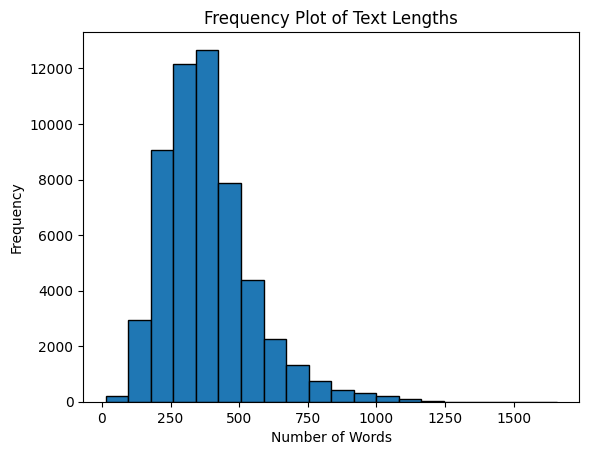

In [11]:
plt.hist(text_lengths, bins=20, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Text Lengths')
plt.savefig('text_length_distribution.png', format='png', dpi=300)  # dpi=300 for high quality
plt.show()

In [12]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)


/spack/conda/miniforge3/24.3.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Split into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(
    daigt_external_data, test_size=0.2, random_state=42, stratify=daigt_external_data['generated']
)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 43752
Testing samples: 10939


In [14]:
#The size of the data above leads to long compute times in processing the data (into vectors of probabilites) and to train the neural network). Let's therefore use a smaller dataset to begin with
small_data = daigt_external_data.sample(n=2400, random_state=42)
small_train_data, small_test_data = train_test_split(
    small_data, test_size=400, random_state=42, stratify=small_data['generated']
)

print(f"Training samples: {len(small_train_data)}")
print(f"Testing samples: {len(small_test_data)}")
print(small_test_data['text'])

Training samples: 2000
Testing samples: 400
27434    Extracurricular activities\n\nStudents should ...
2592     There is no doubt that advertising can make pr...
14311    “A Cowboy Who Rode the Waves.” This title may ...
53010    I say no becuase you cannot jude somonw by the...
21887    There are so many advantages of limiting car u...
                               ...                        
49876     If I were to choose a place to visit, I would...
25263    Based on the infomation that I was given,I kno...
42994    First I think so because of the fact that peop...
2549     There is no doubt that it is better to have br...
30611    Professor Thomas Huang has a initiative way of...
Name: text, Length: 400, dtype: object


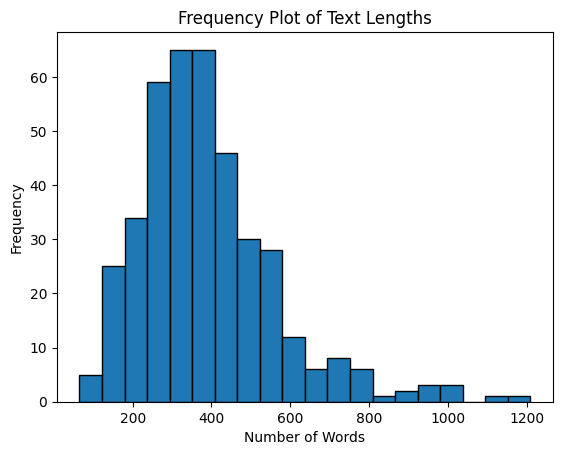

In [15]:
text_lengths = []
for text in small_test_data['text']:
    words = text.split()
    text_lengths.append(len(words))
#print(text_lengths)
plt.hist(text_lengths, bins=20, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Text Lengths')
plt.savefig('text_length_distribution.png', format='png', dpi=300)  # dpi=300 for high quality
plt.show()

# Classify based on last hidden state

In [16]:
#list of models to try:     
#Tried:
#model_name = 'gpt2'
#model_name = 'meta-llama/Llama-3.2-1B'
model_name = "meta-llama/Llama-3.2-3B-Instruct"
#model_name = 'mistralai/Mistral-7B-v0.1' - too slow
#model_name = 'google/gemma-2-2b'
#Yet to try:
#model_name = 'EleutherAI/gpt-neo-125M'
#model_name = 'distilgpt2'
#model_name = 'tiiuae/falcon-7b'
#model_name = 'nvidia/Llama-3.1-Nemotron-70B-Instruct-HF'
#model_name = 'meta-llama/Llama-3.1-8B-Instruct'


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, return_dict_in_generate=True, output_hidden_states=True)

Loading checkpoint shards: 100%|██████████| 2/2 [00:55<00:00, 27.70s/it]


In [17]:
# Define function to get last token embedding
def get_last_token_embedding(text, tokenizer, model, max_length=512):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    last_hidden_state = hidden_states[-1]  # Last layer's hidden state
    last_token_embedding = last_hidden_state[0, -1, :]  # [batch_idx, token_idx, hidden_size]
    return last_token_embedding.numpy()

In [18]:
get_last_token_embedding("Hello, how are you toady?", tokenizer, model)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


array([ 0.3592204 ,  0.93713605, -1.0850223 , ..., -0.82517856,
       -1.0076083 ,  0.6903442 ], dtype=float32)

In [19]:
def generate_llama_response(prompt, max_new_tokens=50, temperature=0.7):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)

    generate_ids = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=inputs["input_ids"].shape[1] + max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,  # Avoid warnings
        do_sample=True,       # important to enable sampling
        temperature=temperature
    )

    full_text = tokenizer.decode(generate_ids[0], skip_special_tokens=True)
    completion = full_text[len(prompt):].strip()
    return completion

In [20]:
#Example usage
my_prompt = "Tell me a story about an happy wise boy in a forest."
response = generate_llama_response(my_prompt, max_new_tokens=50, temperature=0.8)
print("Prompt:", my_prompt)
print("Response:", response)

Prompt: Tell me a story about an happy wise boy in a forest.
Response: in the of the forest there is a magical river that flows from a secret waterfall, which has the healing powers of nature.
The boy, named Kaito, has been drawn to the river for many years, and he knows its secrets. He


In [11]:
# Process training data
X_train = []
y_train = []

print("Processing training data...")
for idx, row in tqdm(small_train_data.iterrows(), total=len(small_train_data)):
    text = row['text']
    label = row['generated']
    try:
        embedding = get_last_token_embedding(text, tokenizer, model)
        X_train.append(embedding)
        y_train.append(label)
    except Exception as e:
        print(f"Error processing text at index {idx}: {e}")


# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
# Save the numpy arrays to .npy files
np.save('X_train_gemma-2-2b_embed.npy', X_train)
np.save('y_train_gemma-2-2b_embed.npy', y_train)

# Process testing data
X_test = []
y_test = []

print("Processing testing data...")
for idx, row in tqdm(small_test_data.iterrows(), total=len(small_test_data)):
    text = row['text']
    label = row['generated']
    try:
        embedding = get_last_token_embedding(text, tokenizer, model)
        X_test.append(embedding)
        y_test.append(label)
    except Exception as e:
        print(f"Error processing text at index {idx}: {e}")


X_test = np.array(X_test)
y_test = np.array(y_test)
# Save the numpy arrays to .npy files
np.save('X_test_gemma-2-2b_embed.npy', X_test)
np.save('y_test_gemma-2-2b_embed.npy', y_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Processing training data...


100%|██████████| 2000/2000 [1:16:53<00:00,  2.31s/it]


Processing testing data...


100%|██████████| 400/400 [12:35<00:00,  1.89s/it]

X_train shape: (2000, 2304)
X_test shape: (400, 2304)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [22]:
# Train Random Forest classifier

import matplotlib.pyplot as plt
X_train = np.load('X_train_GPT2_embed.npy')
y_train = np.load('y_train_GPT2_embed.npy')
X_test = np.load('X_test_GPT2_embed.npy')
y_test = np.load('y_test_GPT2_embed.npy')
clf_gpt2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf_gpt2.fit(X_train, y_train)

# Evaluate the model
y_pred = clf_gpt2.predict(X_test)
print(y_pred)

[0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0
 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1
 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1
 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1
 1 0 0 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0
 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0
 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1
 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1
 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0]


In [23]:

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix for labels 0 (Human) and 1 (AI)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index=[f"True {label}" for label in ["Human", "AI"]],
    columns=[f"Pred {label}" for label in ["Human", "AI"]]
)

print("\nConfusion Matrix:")
print(cm_df)

Test Accuracy: 0.9500

Confusion Matrix:
            Pred Human  Pred AI
True Human         223        3
True AI             17      157


In [24]:
# 1) Categorize by text length
# Create a list (or array) of categories for each test example
length_categories = []
for length in text_lengths:
    if length < 300:
        length_categories.append('<300')
    elif length < 400:
        length_categories.append('300-399')
    elif length < 500:
        length_categories.append('400-499')
    else:
        length_categories.append('≥500')

length_categories = np.array(length_categories)

# 2) Compute accuracy (or error) per category
unique_cats = np.unique(length_categories)

print("\nAccuracy by Text-Length Category:")
for cat in unique_cats:
    # Find all indices that belong to this category
    cat_indices = np.where(length_categories == cat)[0]
    
    # Select the subset of true labels and predictions
    y_true_cat = y_test[cat_indices]
    y_pred_cat = y_pred[cat_indices]
    
    # Compute accuracy for this subset
    cat_accuracy = accuracy_score(y_true_cat, y_pred_cat)
    
    print(f"  Category '{cat}':")
    print(f"    Number of samples = {len(cat_indices)}")
    print(f"    Accuracy = {cat_accuracy:.4f}")


Accuracy by Text-Length Category:
  Category '300-399':
    Number of samples = 118
    Accuracy = 0.9492
  Category '400-499':
    Number of samples = 72
    Accuracy = 0.9583
  Category '<300':
    Number of samples = 131
    Accuracy = 0.9618
  Category '≥500':
    Number of samples = 79
    Accuracy = 0.9241


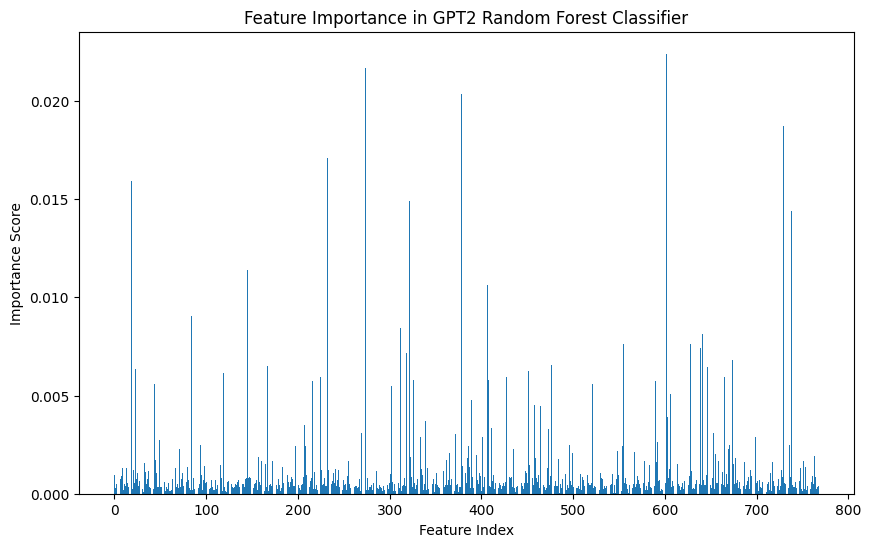

In [25]:
# Feature importances
feature_importances = clf_gpt2.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in GPT2 Random Forest Classifier")
plt.show()


In [24]:
# Assuming you have already trained the classifier and obtained feature_importances
important_features = [index for index, importance in enumerate(feature_importances) if importance > 0.015]

# Print or return the list of important feature indices
print("Features with importance score above 0.015:", important_features)

Features with importance score above 0.015: [6, 19, 232, 274, 378, 526, 602, 635, 683, 696, 729]


In [26]:
#try random forest with Llamma 3.2-1B

import matplotlib.pyplot as plt
X_train = np.load('X_train_Llama-3.2-1B_embed.npy')
y_train = np.load('y_train_Llama-3.2-1B_embed.npy')
X_test = np.load('X_test_Llama-3.2-1B_embed.npy')
y_test = np.load('y_test_Llama-3.2-1B_embed.npy')
clf_llama_3_2_1B = RandomForestClassifier(n_estimators=100, random_state=42)
clf_llama_3_2_1B.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Evaluate the model
y_pred = clf_llama_3_2_1B.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix for labels 0 (Human) and 1 (AI)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index=[f"True {label}" for label in ["Human", "AI"]],
    columns=[f"Pred {label}" for label in ["Human", "AI"]]
)

print("\nConfusion Matrix:")
print(cm_df)


Test Accuracy: 0.9725

Confusion Matrix:
            Pred Human  Pred AI
True Human         223        3
True AI              8      166


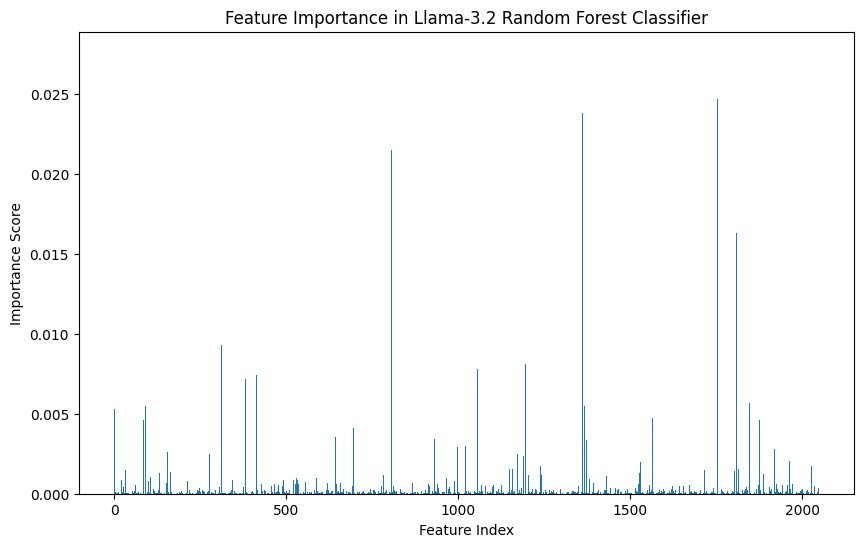

In [39]:
# Feature importances
feature_importances = clf_llama_3_2_1B.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Llama-3.2 Random Forest Classifier")
plt.show()


In [28]:
import matplotlib.pyplot as plt
X_train = np.load('X_train_gemma-2-2b_embed.npy')
y_train = np.load('y_train_gemma-2-2b_embed.npy')
X_test = np.load('X_test_gemma-2-2b_embed.npy')
y_test = np.load('y_test_gemma-2-2b_embed.npy')
clf_gemma = RandomForestClassifier(n_estimators=100, random_state=42)
clf_gemma.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [29]:
# Evaluate the model
y_pred = clf_gemma.predict(X_test)

print(X_train.shape)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Compute the confusion matrix for labels 0 (Human) and 1 (AI)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(
    cm,
    index=[f"True {label}" for label in ["Human", "AI"]],
    columns=[f"Pred {label}" for label in ["Human", "AI"]]
)

print("\nConfusion Matrix:")
print(cm_df)

(2000, 2304)
Test Accuracy: 0.9750

Confusion Matrix:
            Pred Human  Pred AI
True Human         224        2
True AI              8      166


### Let's look at some of the texts that were misclassified: 

In [30]:
import numpy as np

# Get indices of misclassified examples
misclassified_indices = np.where(y_pred != y_test)[0]

print("Misclassified Examples:")
for idx in misclassified_indices:
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    # Assuming your original DataFrame (for test data) is small_test_data
    text = small_test_data.iloc[idx]['text']
    print(f"Index: {idx} | True: {'Human' if true_label == 0 else 'AI'} | Predicted: {'Human' if pred_label == 0 else 'AI'}")
    print("Text:")
    print(text)
    print("=" * 80)

Misclassified Examples:
Index: 58 | True: AI | Predicted: Human
Text:
 Albert Schweitzer once said, "Example is not the main thing in influencing others; it is the only thing." However, it is a good example by your own behavior the best way to influence other people. People may follow every step you do, because they want to success in life by being influenced by others. It is the main thing to show people that they can do what they think they are not able to do.

Firstly, people may follow every step you do, because they want to success in life by being influenced by others. For instance, my friend John has a daughter who wants to become a doctor. John's wife, whose name is Sarah, is a doctor herself. Although their daughter, Sarah, is taking only biology classes in college, which it has nothing to do with medicine. John and Sarah want to influence Sarah to become a doctor. But Sarah is being influenced by her English teacher. Sarah has a very high score on English, and her teacher bel

### Now let's look at some correctly classified text: 

In [32]:
import numpy as np

# Get indices of misclassified examples
correctly_classified_indices = np.where(y_pred == y_test)[0]

print("Misclassified Examples:")
count = 0
for idx in correctly_classified_indices:
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    # Assuming your original DataFrame (for test data) is small_test_data
    text = small_test_data.iloc[idx]['text']
    print(f"Index: {idx} | True: {'Human' if true_label == 0 else 'AI'} | Predicted: {'Human' if pred_label == 0 else 'AI'}")
    print("Text:")
    print(text)
    print("=" * 80)
    count += 1
    if count == 5:
        break

Misclassified Examples:
Index: 0 | True: Human | Predicted: Human
Text:
Extracurricular activities

Students should have extracurricular activities.

Having extracurricular activities can benefit students in many different ways.

First, when students have extracurricular activities, it will make them want to try harder in school.

When students try harder in school, their grades may increase.

When their grades increase, they have a better chance of getting a job than what other students have.

Students could push themselves to success depending on what activity they have.

Second, when students get the chance to have more activities, they could be inspired about their future occupation.

Having extracurricular activities could inspire kids to get jobs and want them to become successful.

When students have this opportunity, it could help them see their future.

If a student does not have the activity that they were hoping for, there are still more activities for the student to chose f

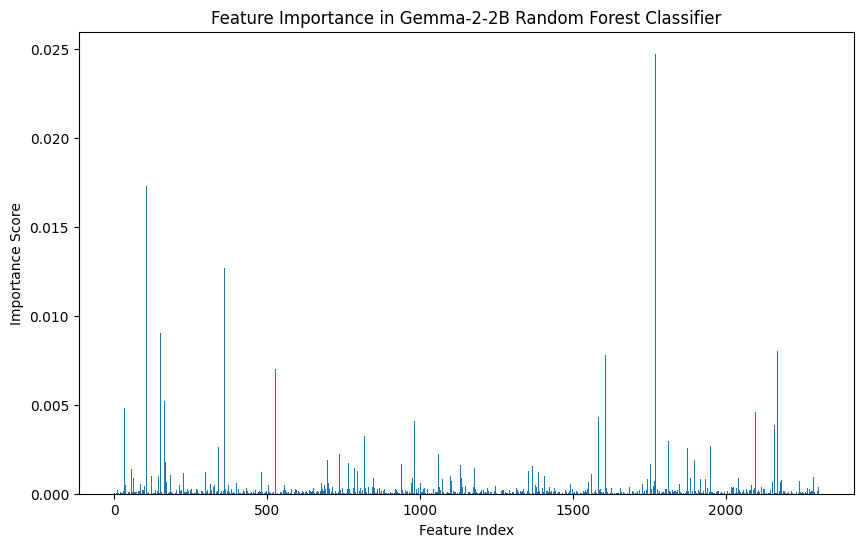

In [26]:
# Feature importances
feature_importances = clf_gemma.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.title("Feature Importance in Gemma-2-2B Random Forest Classifier")
plt.show()

Below are some trials with particular pieces of text not in the train or test data, just some setences I picked at random. 

## Next Steps

- Investigate how classification accuracy varies with the length of the text
- Each prediction requires calling the huge LLM... Any way to speed this up?
- Are there some hidden patterns in the data set that the Random Forest is catching onto? 

## Let's try some text from the latest chat GPT and one of my undergrad essays

In [51]:
ai_text = 'Sleeping well and exercising regularly are foundational pillars for both physical and mental health. Quality sleep allows the body to recover, repair, and recharge. During sleep, essential processes such as muscle repair, immune function strengthening, and memory consolidation occur, all of which are vital for maintaining good health. Poor sleep, on the other hand, can lead to weakened immunity, cognitive issues, and increased stress levels. People who get adequate sleep tend to have better concentration, more stable emotions, and a lower risk of developing chronic health conditions. Exercise complements sleep by boosting physical health, mental clarity, and energy levels. Regular physical activity strengthens the cardiovascular system, enhances lung capacity, and increases muscle tone. Exercise also releases endorphins, the body’s natural mood enhancers, which help reduce stress and promote happiness. People who exercise regularly often experience deeper and more restorative sleep, as physical exertion helps regulate the sleep-wake cycle, making it easier to fall asleep and stay asleep. Together, sleep and exercise create a positive feedback loop that amplifies overall wellness. Good sleep boosts energy, which leads to better workouts; effective exercise further promotes quality sleep, creating a cycle of health benefits. This synergy between sleep and exercise not only improves immediate well-being but also supports long-term health by reducing the risks of heart disease, diabetes, and mental health disorders. Therefore, prioritizing both good sleep and regular exercise is essential for living a balanced, healthy, and fulfilling life.'
gemma_embedding = np.array([get_last_token_embedding(ai_text, tokenizer, model)])
y_pred = clf_gemma.predict(gemma_embedding)
print(y_pred)

[1]


In [53]:
human_text = 'The use of animals for research and testing has been a part of human practice for thousands of years, giving our species a variety of medical and commercial products. However, it bears a heavy ethical burden: do we have the right to treat other species however we want? Is the suffering endured by the millions of animals across the globe every year compensated by the benefits we extract? The issue of animal testing is complex and intricate, with both sides presenting strong arguments. To understand both positions well, and therefore to push ourselves closer to some sort of balance between the good and the bad, let us examine some arguments from either side. One of the primary arguments on the pro-testing side is that, historically, animal testing has led to some of the most powerful breakthroughs in all of medicine. From the vivisections of ancient Greece to the discovery of penicillin in the 20th century, the study of and experimentation with animal anatomy has formed the basis of biomedical research. In the past century alone, the use of animals in experiments has led to the ability to conduct successful blood transfusions, to combat asthma, to create vaccines for Meningitis, to transplant kidneys, and to the suppression of Tuberculosis. Within this short list, hundreds of millions of lives have either been saved or been dramatically improved. The full extent of the benefits is truly incalculable. [1,2] The opposition to this viewpoint, acknowledging the benefits mentioned above, still think that this form of testing is morally indefensible. Each year, ignoring all the experiments and tests done outside the U.S., approximately 100 million mice and rats are used in experiments, plus about 1 million animals from other species (excluding mice, rats, birds, reptiles, agricultural animals). In the United Kingdom, out of about 2 million experimental procedures completed in 2015, 150 thousand of them were classified as “severe”, which denotes experiments that cause long-term disease, the need for assistance for basic processes like eating and drinking, and the provocation of self-mutilation due to high levels of stress.[3] Some animals are forced to inhale toxic fumes, have holes drilled into their skulls, have their skin burned off, or their spinal cords crushed. Therefore, one needs to consider not only the number of deaths caused by medical training, experimentation and testing (about 100,000,000 per year in the U.S.) [3], but also the unimaginable levels of suffering and misery these conscious beings experience before their deaths.'
gemma_embedding = np.array([get_last_token_embedding(human_text, tokenizer, model)])
y_pred = clf_gemma.predict(gemma_embedding)
print(y_pred)


[0]
